In [13]:
import requests
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *

page = 1
url = f"http://ocr.iguidevietnam.com/processes/2e096e71-8b8b-4f54-2178-08dc3b63fec5/items?status=done&page={page}&size=10"

response = requests.get(url)
response = response.json()
print(response['totalItems'])
# print(response)
annotation_data = []
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists('data/imgs'):
    os.mkdir('data/imgs')

for page in range (1, response['totalPages']+1):
# for page in range (1,2):
    url = f"http://ocr.iguidevietnam.com/processes/2e096e71-8b8b-4f54-2178-08dc3b63fec5/items?status=done&page={page}&size=10"
    response = requests.get(url)
    response = response.json()
    # print(response['totalItems'])
    for item in response['items']:
        img_response = requests.get(item['image'])
        nparr = np.fromstring(img_response.content, np.uint8)

        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        # img = Image.open(BytesIO(response.content))
        for box in item['result']['textboxes']:
            coordinates = [[c['x'], c['y']] for c in box["bndbox"]]
            if len(coordinates) != 4 or box['label'] == 'manufactured_country':
                continue
            h = np.sqrt((coordinates[0][0] - coordinates[1][0])**2 + (coordinates[0][1] - coordinates[1][1])**2)
            w = np.sqrt((coordinates[1][0] - coordinates[2][0])**2 + (coordinates[1][1] - coordinates[2][1])**2)
            homo, status = cv2.findHomography(np.array(coordinates), np.array([[0,0],[0,h],[w,h],[w,0]]))
            trans_img = cv2.warpPerspective(img, homo, (int(w),int(h)))
            file_name = add_to_end_of_filename(item['name'], box['label'])
            file_path = f'imgs/{file_name}'
            cv2.imwrite(f'data/{file_path}', trans_img)
            annotation_data.append(f"{file_path}\t{box['text']}\n")
            # visualize_opencv_image(trans_img)
            # print(box['text'])

import random
random.shuffle(annotation_data)
train_test_ratio = 0.7
index = round(len(annotation_data)*train_test_ratio)
print(index)

#write back the file
with open("data/train_annotation.txt","w") as f:
    f.writelines(annotation_data[:index])
with open("data/test_annotation.txt","w") as f:
    f.writelines(annotation_data[index:])

407


/tmp/ipykernel_393358/2193283418.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(img_response.content, np.uint8)


3116


# Train model



1.   Load your config
2.   Train model using your dataset above



Load the default config, we adopt VGG for image feature extraction

In [14]:
from vietocr.tool.config import Cfg
from vietocr.model.trainer import Trainer

# Change the config 

* *data_root*: the folder save your all images
* *train_annotation*: path to train annotation
* *valid_annotation*: path to valid annotation
* *print_every*: show train loss at every n steps
* *valid_every*: show validation loss at every n steps
* *iters*: number of iteration to train your model
* *export*: export weights to folder that you can use for inference
* *metrics*: number of sample in validation annotation you use for computing full_sequence_accuracy, for large dataset it will take too long, then you can reuduce this number


In [34]:
config = Cfg.load_config_from_name('vgg_transformer')

In [35]:

dataset_params = {
    'name':'gdk',
    'data_root':'./data/',
    'train_annotation':'train_annotation.txt',
    'valid_annotation':'test_annotation.txt'
}

params = {
         'print_every':200,
         'valid_every':15*200,
          'iters':20000,
          'checkpoint':'./checkpoint/transformerocr_checkpoint.pth',    
          'export':'./weights/transformerocr.pth',
          'metrics': 10000
         }

config['trainer'].update(params)
config['dataset'].update(dataset_params)
config['aug']['image_aug']= False
# config['device'] = 'cuda:0'
config['device'] = 'cpu'

you can change any of these params in this full list below

In [36]:
config

{'vocab': 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
 'device': 'cpu',
 'seq_modeling': 'transformer',
 'transformer': {'d_model': 256,
  'nhead': 8,
  'num_encoder_layers': 6,
  'num_decoder_layers': 6,
  'dim_feedforward': 2048,
  'max_seq_length': 1024,
  'pos_dropout': 0.1,
  'trans_dropout': 0.1},
 'optimizer': {'max_lr': 0.0003, 'pct_start': 0.1},
 'trainer': {'batch_size': 32,
  'print_every': 200,
  'valid_every': 3000,
  'iters': 20000,
  'export': './weights/transformerocr.pth',
  'checkpoint': './checkpoint/transformerocr_checkpoint.pth',
  'log': './train.log',
  'metrics': 10000},
 'dataset': {'name': 'gdk',
  'data_root': './data/',
  'train_annotation': 'train_annotation.txt',
  'valid_annotation': 'test_annotation.txt',
  'image_height': 32,
  'image_min_width': 32,
  'image_max_wi

You should train model from our pretrained 

In [37]:
trainer = Trainer(config, pretrained=True)

Model weight /tmp/vgg_transformer.pth exsits. Ignore download!


Create train_gdk: 100%|███████████████████████████████████████| 3116/3116 [00:00<00:00, 4995.04it/s]

Created dataset with 3115 samples



Create valid_gdk:  50%|████████████████████                    | 672/1336 [00:00<00:00, 6691.13it/s]

not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)


Create valid_gdk: 100%|███████████████████████████████████████| 1336/1336 [00:00<00:00, 5168.59it/s]

Remove 2 invalid images
Created dataset with 1333 samples



valid_gdk build cluster: 100%|██████████████████████████████| 1333/1333 [00:00<00:00, 248411.93it/s]


Save model configuration for inference, load_config_from_file

In [38]:
trainer.config.save('config.yml')

Visualize your dataset to check data augmentation is appropriate

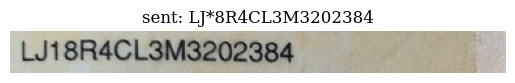

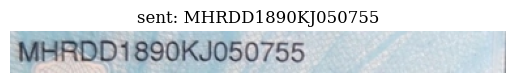

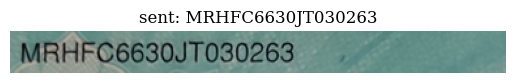

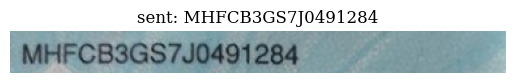

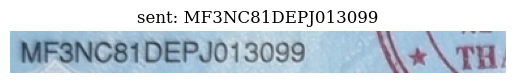

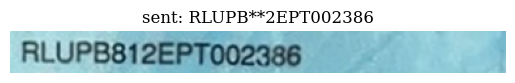

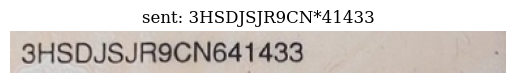

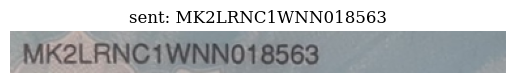

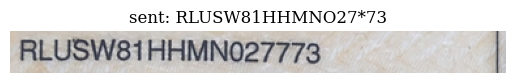

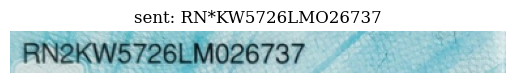

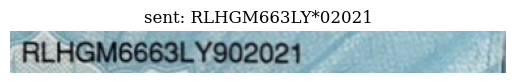

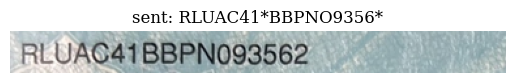

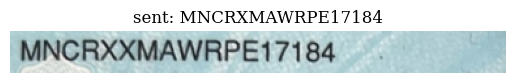

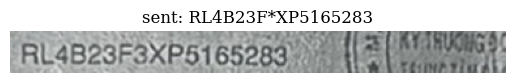

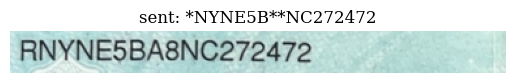

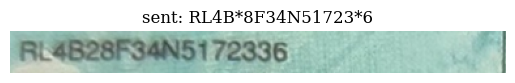

In [48]:
trainer.visualize_dataset()

Train now

In [9]:
trainer.train()

/home/hung/PycharmProjects/ocr-training/venv/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KeyboardInterrupt: 

Visualize prediction from our trained model


In [ ]:
trainer.visualize_prediction()

Compute full seq accuracy for full valid dataset

In [ ]:
trainer.precision()